In [21]:
import os
import json
import sqlite3

import pandas as pd
import matplotlib as plt

In [22]:
filepath = 'data user2/'

In [23]:
data = []

for filename in os.listdir(filepath):
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))

In [24]:
df = pd.concat(data, ignore_index = True)

In [25]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
#df['VALUE'] = df['VALUE'].str.lower()

In [26]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [27]:
df = df.sort_values(by = ['MEASUREMENT_TIME'], ignore_index = True)

In [28]:
df

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2023-01-19 20:06:06.546,3,esrv.exe,0
1,2023-01-19 20:06:06.546,9,701,0
2,2023-01-19 20:06:06.546,8,182,0
3,2023-01-19 20:06:06.546,7,1175,0
4,2023-01-19 20:06:06.546,6,182,0
...,...,...,...,...
11623,2023-01-23 17:56:44.898,5,ConsoleWindowClass,0
11624,2023-01-23 17:56:44.898,10,0,0
11625,2023-01-23 17:56:44.898,3,esrv.exe,0
11626,2023-01-23 17:56:44.898,1,12084,0


In [29]:
shape = df.shape
print("Number of data points collected so far: " + str(shape[0]))

Number of data points collected so far: 11628


In [30]:
schema[['ID_INPUT', 'INPUT_NAME', 'INPUT_DESCRIPTION']]

,ID_INPUT,INPUT_NAME,INPUT_DESCRIPTION
0,0,FOREGROUND-WIND(0),Foreground Window Root ID
1,1,FOREGROUND-WIND(1),Foreground Window Process ID
2,2,FOREGROUND-WIND(2),Foreground Window Thread ID
3,3,FOREGROUND-WIND(3),Foreground Window Name
4,4,FOREGROUND-WIND(4),Foreground Window Image Name
5,5,FOREGROUND-WIND(5),Foreground Window Class Name
6,6,FOREGROUND-WIND(6),Window Upper Left X Coordinate
7,7,FOREGROUND-WIND(7),Window Lower Right X Coordinate
8,8,FOREGROUND-WIND(8),Window Upper Left Y Coordinate
9,9,FOREGROUND-WIND(9),Window Lower Right Y Coordinate


In [31]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

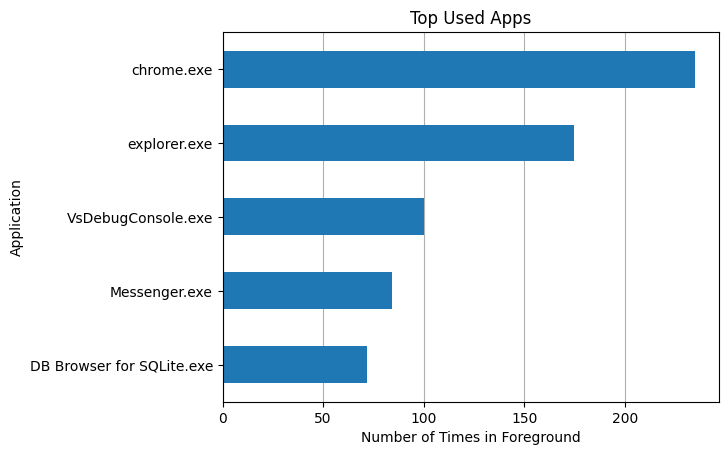

In [32]:
plot = df[df['ID_INPUT'] == 4]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plot.set_axisbelow(True)
plot.set_xlabel('Number of Times in Foreground')
plot.set_ylabel('Application')
plot.set_title('Top Used Apps')
plot.invert_yaxis()
plt.pyplot.grid(axis = 'x')
plt.pyplot.show()

In [40]:
df[df['ID_INPUT'] == 3]['VALUE'].unique()
#unable to open process is when we use command prompt as an adminstrator

array(['esrv.exe', 'Foreground - Microsoft Visual Studio',
       'How to Configure a C/C++ Project in VS - Google Docs - Google Chrome',
       'Messenger', 'sdk',
       'Public -- 2022-2023 (CCG DCA UCSD-HDSI Capstone) | Microsoft Teams',
       'Search', 'Administrator: Command Prompt',
       'Installation - pip documentation v22.3.1 - Google Chrome',
       'Missing String.', 'Program Manager',
       'Python Release Python 3.11.1 | Python.org - Google Chrome',
       'Python 3.11.1 (64-bit) Setup',
       'How to install Jupyter Notebook on Windows? - GeeksforGeeks - Google Chrome',
       'windows - Python command not working in command prompt - Stack Overflow - Google Chrome',
       'System Properties', 'Edit environment variable',
       'Administrator: Command Prompt - py', 'New Tab - Google Chrome',
       'Opening Jupyter Notebook - Google Chrome',
       'Home Page - Select or create a notebook - Google Chrome',
       'Administrator: Command Prompt - py  -m notebook',
 

In [34]:
df_string['MEASUREMENT_TIME'].min()

'2023-01-23 17:56:04.607'

In [35]:
df_string['MEASUREMENT_TIME'].max()

'2023-01-23 17:56:44.898'

In [36]:
df[df['ID_INPUT'] == 10]['VALUE'].unique()

array([0], dtype=object)

In [37]:
#df.to_csv('dataUser2.csv')